In [1]:
import warnings

warnings.filterwarnings("ignore")

## Quickstart

* here's some monthly historic sales data
* typical retail use case - goal is to predict sales count in future months

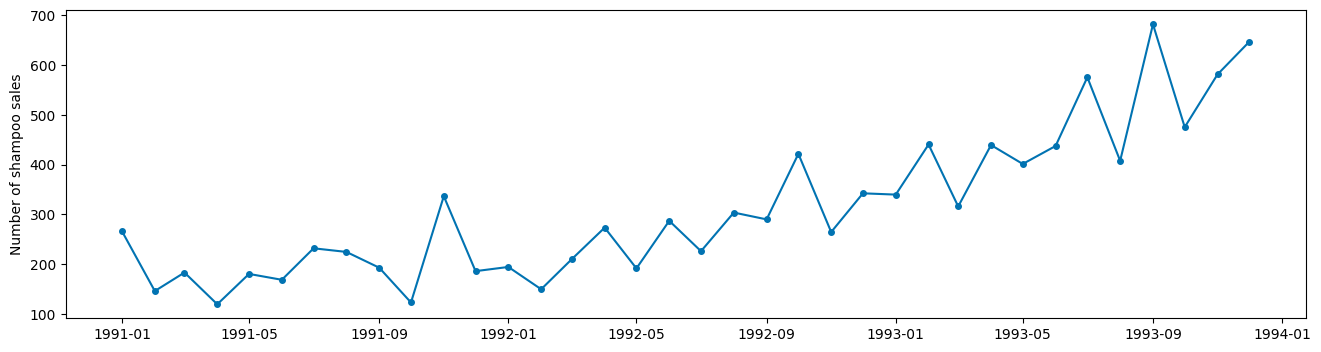

In [2]:
from sktime.datasets import load_shampoo_sales
from sktime.utils import plot_series

y = load_shampoo_sales()

_ = plot_series(y)

In [3]:
y.head()

1991-01    266.0
1991-02    145.9
1991-03    183.1
1991-04    119.3
1991-05    180.3
Freq: M, Name: Number of shampoo sales, dtype: float64

let's split intro train+test subsets

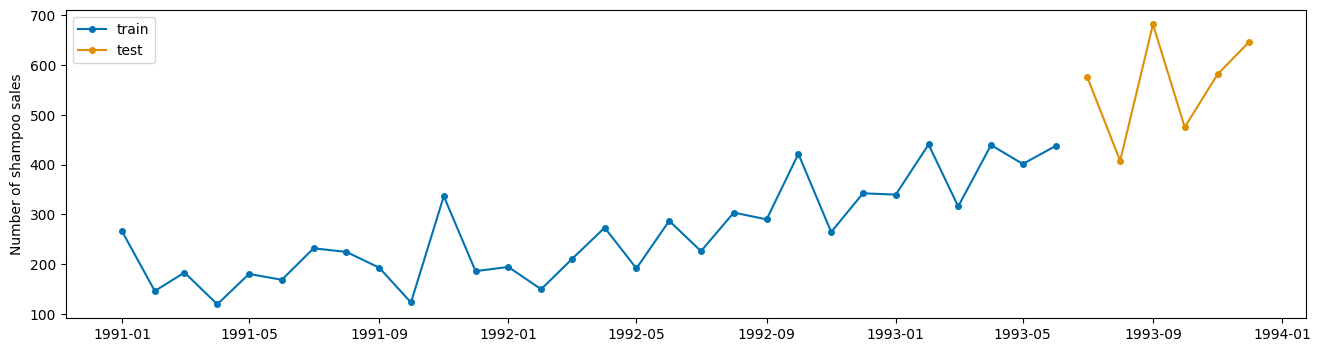

In [4]:
from sktime.split import temporal_train_test_split

y_train, y_test = temporal_train_test_split(y, test_size=6)

_ = plot_series(y_train, y_test, labels=["train", "test"])

In [5]:
y_train.head()

1991-01    266.0
1991-02    145.9
1991-03    183.1
1991-04    119.3
1991-05    180.3
Freq: M, Name: Number of shampoo sales, dtype: float64

In [6]:
y_test.head()

1993-07    575.5
1993-08    407.6
1993-09    682.0
1993-10    475.3
1993-11    581.3
Freq: M, Name: Number of shampoo sales, dtype: float64

we can use the exponential smoothing model, and make the modelling choice of error, trend and seasonality automated using an information criterion.

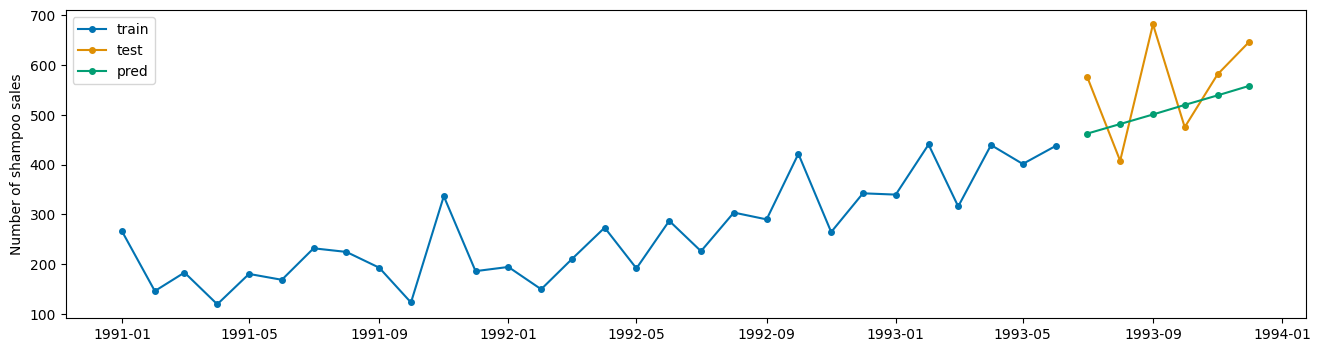

In [7]:
from sktime.forecasting.ets import AutoETS

# 1) Define the model
forecaster = AutoETS(auto=True)

# 2) Fit on train data
fh = [1, 2, 3, 4, 5, 6]  # Forecast horizon relative to y_train
forecaster.fit(y_train, fh=fh)

# 3) Use fitted model to predict
y_pred = forecaster.predict()

_ = plot_series(y_train, y_test, y_pred, labels=["train", "test", "pred"])

* scoring using `sktime` performance metrics
* requires forecasts & true values as `sktime` compatible time series

In [8]:
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError

smape = MeanAbsolutePercentageError(symmetric=True)

print(f"AutoETS - sMAPE error: {smape(y_test, y_pred):.1%}")

AutoETS - sMAPE error: 16.7%


Notes:

* sMAPE just for illustration - not always best choice
* for robust evaluation & comparison, use backtesting (not single train/test split)

## Exogenous Features

* we shall use classic Longley dataset
* our target variable of interest will be number of employed people
* other available features are various US macroeconomic features, known to be highly collinear

In [9]:
from sktime.datasets import load_longley

y, X = load_longley()

In [10]:
y.head()

Period
1947    60323.0
1948    61122.0
1949    60171.0
1950    61187.0
1951    63221.0
Freq: A-DEC, Name: TOTEMP, dtype: float64

In [11]:
X.head()

,GNPDEFL,GNP,UNEMP,ARMED,POP
Period,,,,,
1947,83.0,234289.0,2356.0,1590.0,107608.0
1948,88.5,259426.0,2325.0,1456.0,108632.0
1949,88.2,258054.0,3682.0,1616.0,109773.0
1950,89.5,284599.0,3351.0,1650.0,110929.0
1951,96.2,328975.0,2099.0,3099.0,112075.0


In [12]:
from sktime.split import temporal_train_test_split

y_train, y_test, X_train, X_test = temporal_train_test_split(y, X=X, test_size=4)

In [13]:
y_train.head()

Period
1947    60323.0
1948    61122.0
1949    60171.0
1950    61187.0
1951    63221.0
Freq: A-DEC, Name: TOTEMP, dtype: float64

In [14]:
y_train.head()

Period
1947    60323.0
1948    61122.0
1949    60171.0
1950    61187.0
1951    63221.0
Freq: A-DEC, Name: TOTEMP, dtype: float64

In [15]:
X_train.head()

,GNPDEFL,GNP,UNEMP,ARMED,POP
Period,,,,,
1947,83.0,234289.0,2356.0,1590.0,107608.0
1948,88.5,259426.0,2325.0,1456.0,108632.0
1949,88.2,258054.0,3682.0,1616.0,109773.0
1950,89.5,284599.0,3351.0,1650.0,110929.0
1951,96.2,328975.0,2099.0,3099.0,112075.0


In [16]:
X_test.head()

,GNPDEFL,GNP,UNEMP,ARMED,POP
Period,,,,,
1959,112.6,482704.0,3813.0,2552.0,123366.0
1960,114.2,502601.0,3931.0,2514.0,125368.0
1961,115.7,518173.0,4806.0,2572.0,127852.0
1962,116.9,554894.0,4007.0,2827.0,130081.0


we will use `ARIMA` estimator, which is built on top of `statsmodels` implementation of SARIMAX

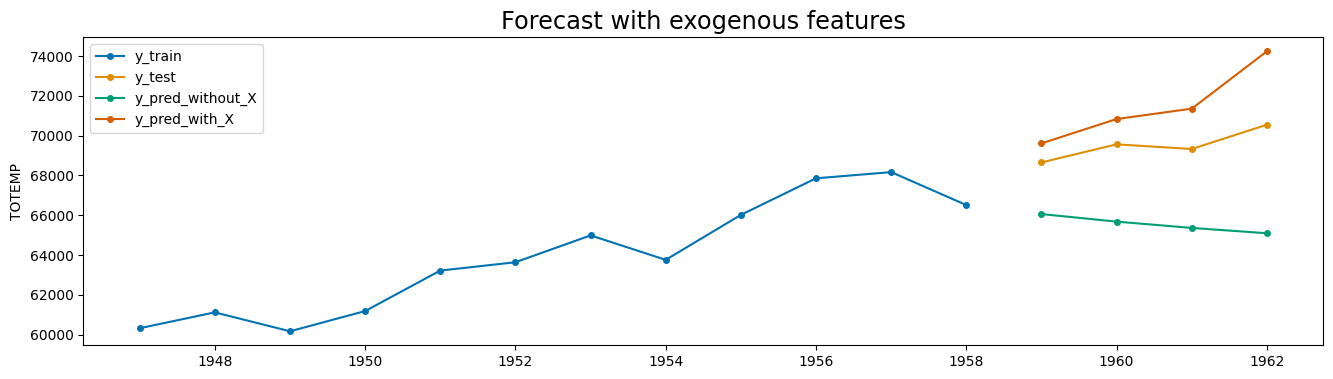

In [17]:
from sktime.forecasting.arima import ARIMA

forecaster_without_X = ARIMA()
forecaster_with_X = ARIMA()

fh = [1, 2, 3, 4]

forecaster_without_X.fit(y_train, fh=fh)
forecaster_with_X.fit(y_train, X=X_train, fh=fh)

y_pred_without_X = forecaster_without_X.predict()
y_pred_with_X = forecaster_with_X.predict(X=X_test)

_ = plot_series(
    y_train,
    y_test,
    y_pred_without_X,
    y_pred_with_X,
    labels=["y_train", "y_test", "y_pred_without_X", "y_pred_with_X"],
    title="Forecast with exogenous features",
)

In [18]:
print(f"ARIMA without X - sMAPE error: {smape(y_test, y_pred_without_X):.1%}")
print(f"ARIMA with X - sMAPE error: {smape(y_test, y_pred_with_X):.1%}")

ARIMA without X - sMAPE error: 5.9%
ARIMA with X - sMAPE error: 2.8%


all forecasters that support exogenous features

In [19]:
from sktime.registry import all_estimators

all_estimators(
    estimator_types="forecaster",
    filter_tags={"ignores-exogeneous-X": True},
    as_dataframe=True,
)

,name,object
0,ARCH,<class 'sktime.forecasting.arch._uarch.ARCH'>
1,AutoETS,<class 'sktime.forecasting.ets.AutoETS'>
2,AutoTS,<class 'sktime.forecasting.autots.AutoTS'>
3,BATS,<class 'sktime.forecasting.bats.BATS'>
4,CurveFitForecaster,<class 'sktime.forecasting.trend._curve_fit_fo...
5,DirRecTabularRegressionForecaster,<class 'sktime.forecasting.compose._reduce.Dir...
6,DirRecTimeSeriesRegressionForecaster,<class 'sktime.forecasting.compose._reduce.Dir...
7,ExponentialSmoothing,<class 'sktime.forecasting.exp_smoothing.Expon...
8,ForecastKnownValues,<class 'sktime.forecasting.dummy.ForecastKnown...
9,ForecastingGridSearchCV,<class 'sktime.forecasting.model_selection._tu...


## Multivariate forecasting

We begin by loading the historical data of a couple of macro indicators, which are reported yearly.

In [20]:
y = X[["GNPDEFL", "GNP"]]

In `sktime` some forecasters such as `VAR()` are purely mutlivariate. Let's use it to make some predictions:

In [21]:
from sktime.forecasting.var import VAR

forecaster = VAR()
forecaster.fit(y, fh=[1, 2, 3])

y_pred = forecaster.predict()
y_pred

,GNPDEFL,GNP
Period,,
1963,121.688295,578514.398653
1964,124.353664,601873.015890
1965,126.847886,625411.588754


here are all the forecasters that support multivariate endogenous features natively

In [22]:
from sktime.registry import all_estimators

all_estimators(
    estimator_types="forecaster",
    filter_tags={"scitype:y": "multivariate"},
    as_dataframe=True,
)

,name,object
0,DynamicFactor,<class 'sktime.forecasting.dynamic_factor.Dyna...
1,VAR,<class 'sktime.forecasting.var.VAR'>
2,VARMAX,<class 'sktime.forecasting.varmax.VARMAX'>
3,VECM,<class 'sktime.forecasting.vecm.VECM'>


But we can also use univariate forecasters to forecast multiple time series! Let's see how this is done using Theta forecasting which is a purely univariate model.

In [23]:
from sktime.forecasting.arima import ARIMA

forecaster = ARIMA()
forecaster.fit(y, fh=[1, 2, 3])

y_pred = forecaster.predict()
y_pred

,GNPDEFL,GNP
Period,,
1963,116.618807,548785.487694
1964,116.342338,542932.337375
1965,116.070512,537323.873818


this is done by separate models per each of the columns

In [24]:
forecaster.forecasters_

,GNPDEFL,GNP
forecasters,ARIMA(),ARIMA()


## Probabilistic Forecasting

The following methods are possibly available for probabilistic forecasts:

- `predict_interval` produces interval forecasts. Additionally to any `predict` arguments, an argument `coverage` (nominal interval coverage) must be provided.
- `predict_quantiles` produces quantile forecasts. Additionally to any `predict` arguments, an argument `alpha` (quantile values) must be provided.
- `predict_var` produces variance forecasts. This has same arguments as `predict`.
- `predict_proba` produces full distributional forecasts. This has same arguments as `predict`.

| Name | param | prediction/estimate of | `sktime` |
| ---- | ----- | ---------------------- | -------- |
| point forecast | | conditional expectation $\mathbb{E}[y'\|y]$ | `predict` |
| variance forecast | | conditional variance $Var[y'\|y]$ | `predict_var` |
| quantile forecast | $\alpha\in (0,1)$ | $\alpha$-quantile of $y'\|y$ | `predict_quantiles` |
| interval forecast | $c\in (0,1)$| $[a,b]$ s.t. $P(a\le y' \le b\| y) = c$ | `predict_interval` |
| distribution forecast | | the law/distribution of $y'\|y$ | `predict_proba` |

In [25]:
y_pred_int = forecaster.predict_interval(coverage=0.95)

y_pred_int

GNPDEFL                        GNP               
              0.95                       0.95               
             lower       upper          lower          upper
Period                                                      
1963    110.969520  122.268094  495844.949269  601726.026118
1964    108.419854  124.264821  469611.334765  616253.339985
1965    106.448178  125.692846  449354.629450  625293.118187

* what if you want for multiple coverages?
* no problem, just pass a list

In [26]:
y_pred_int_multiple = forecaster.predict_interval(coverage=[0.95, 0.9])

y_pred_int_multiple

GNPDEFL                                                GNP  \
              0.95                    0.90                       0.95   
             lower       upper       lower       upper          lower   
Period                                                                  
1963    110.969520  122.268094  111.877776  121.359838  495844.949269   
1964    108.419854  124.264821  109.693580  122.991095  469611.334765   
1965    106.448178  125.692846  107.995194  124.145829  449354.629450   

                                                     
                                0.90                 
                upper          lower          upper  
Period                                               
1963    601726.026118  504356.387299  593214.588089  
1964    616253.339985  481399.412267  604465.262483  
1965    625293.118187  463497.756705  611149.990931

here are the forecasters that support probabilistic capabilities.

In [27]:
from sktime.registry import all_estimators

all_estimators(
    estimator_types="forecaster",
    filter_tags={"capability:pred_int": True},
    as_dataframe=True,
)

,name,object
0,ARCH,<class 'sktime.forecasting.arch._uarch.ARCH'>
1,ARIMA,<class 'sktime.forecasting.arima._pmdarima.ARI...
2,AutoARIMA,<class 'sktime.forecasting.arima._pmdarima.Aut...
3,AutoETS,<class 'sktime.forecasting.ets.AutoETS'>
4,BATS,<class 'sktime.forecasting.bats.BATS'>
5,BaggingForecaster,<class 'sktime.forecasting.compose._bagging.Ba...
6,ColumnEnsembleForecaster,<class 'sktime.forecasting.compose._column_ens...
7,ConformalIntervals,<class 'sktime.forecasting.conformal.Conformal...
8,DartsLinearRegressionModel,<class 'sktime.forecasting.darts.DartsLinearRe...
9,DartsXGBModel,<class 'sktime.forecasting.darts.DartsXGBModel'>


# Forecasting Pipelines

Until now: How can we use sktime to create forecasts.

Now: How can we improve the forecasts.

* endogenous transformation pipelines via `TransformedTargetForecaster`
* parameter estimation using `PluginParamsForecaster`
* forecasting exogenous variables via `ForecastX`

### Transformation pipelines

suppose we want to forecast this well-known dataset
(airline passengers by year in a fixed scope)

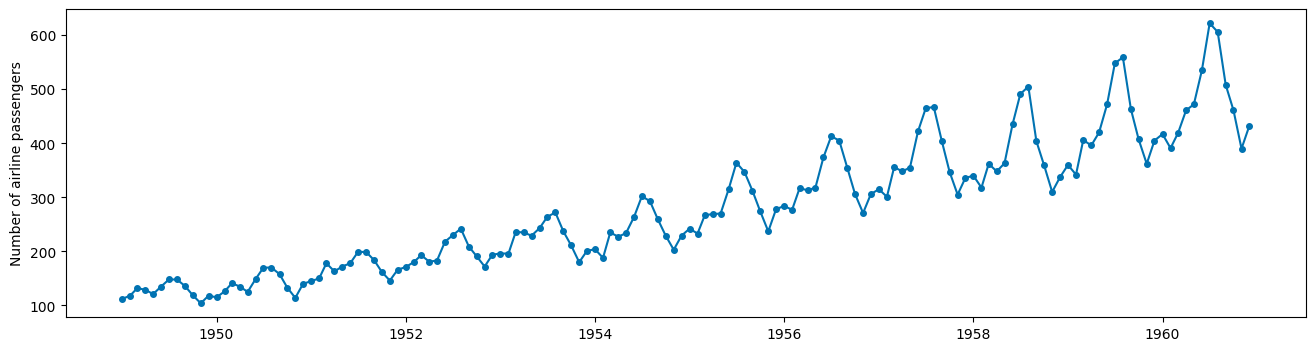

In [28]:
from sktime.datasets import load_airline
from sktime.utils import plot_series

y = load_airline()
_ = plot_series(y)

observations:

* there is monthly seasonality - resets annually - periodicity 12
* trend and seasonality are multiplicative (not additive)

ideas:

* on logarithmic value scale (multiplication becomes addition)
* with seasonality removed

let's see how one will achieve this manually in a complicated sequence of steps, and then we'll take a look at how `sktime` can help to make this much simpler.

#### Manual transformations: doing things the hard way

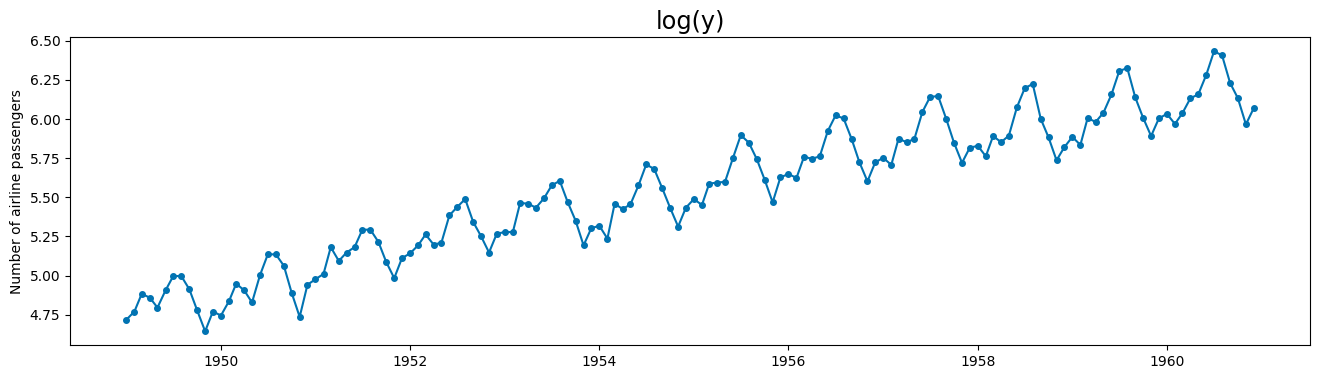

In [29]:
import numpy as np

y_log = np.log(y)

_ = plot_series(y_log, title="log(y)")

this looks additive now!

ok, what next - deaseasonalization

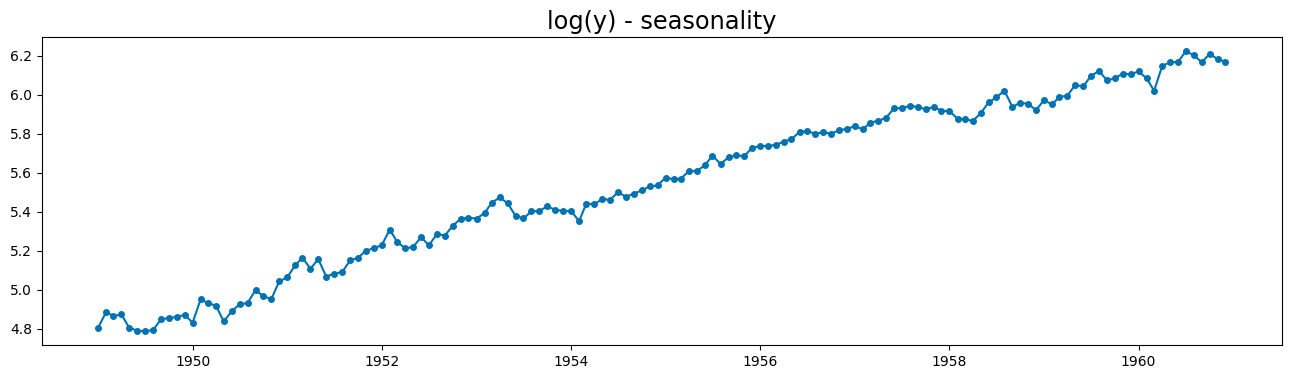

In [30]:
from statsmodels.tsa.seasonal import seasonal_decompose

seasonal_result = seasonal_decompose(y_log, period=12)
seasonal = seasonal_result.seasonal
y_log_deseasonalised = y_log - seasonal

_ = plot_series(y_log_deseasonalised, title="log(y) - seasonality")

now:

* forecast on this
* add back seasonal component
* invert logarithm (exponentiate)

start with forecast...

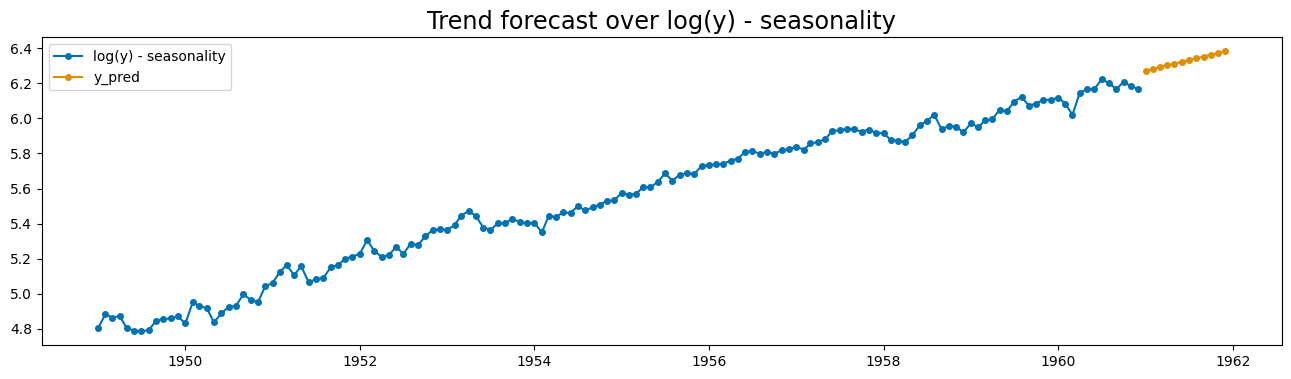

In [31]:
from sktime.forecasting.trend import TrendForecaster

forecaster = TrendForecaster()  # uses OLS by default to fit a linear model

fh = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]  # Alternatively: range(1, 12 + 1)
y_pred = forecaster.fit_predict(y_log_deseasonalised, fh=fh)

_ = plot_series(
    y_log_deseasonalised,
    y_pred,
    labels=["log(y) - seasonality", "y_pred"],
    title="Trend forecast over log(y) - seasonality",
)

looks reasonable!

Now to turn this into a forecast of the original y ...

* add seasonal
* invert the logarithm

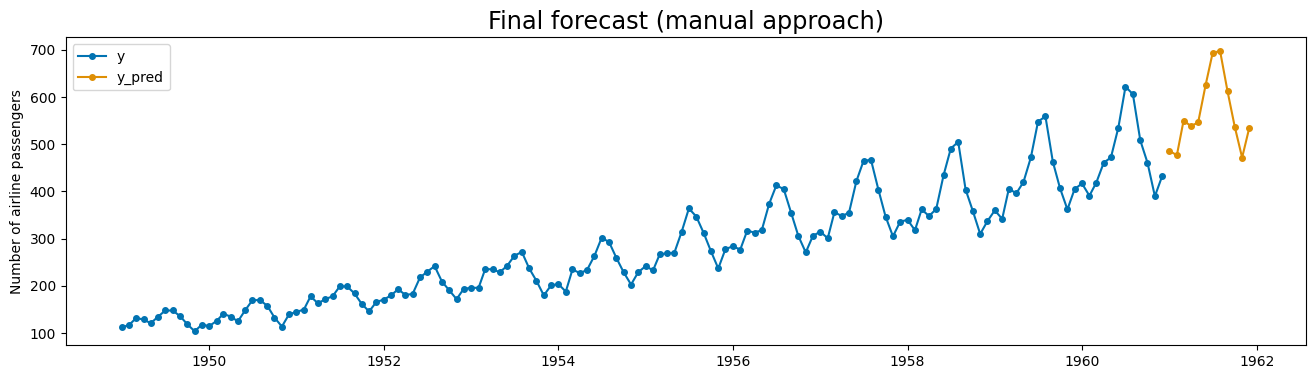

In [32]:
y_pred_add_seasonality = y_pred + seasonal.to_numpy()[:12]
y_pred_orig = np.exp(y_pred_add_seasonality)

_ = plot_series(
    y, y_pred_orig, labels=["y", "y_pred"], title="Final forecast (manual approach)"
)

#### `sktime` transformers: doing things the easier way

Solution: use transformers & pipelines!

Same interface at every step! Easily composable!

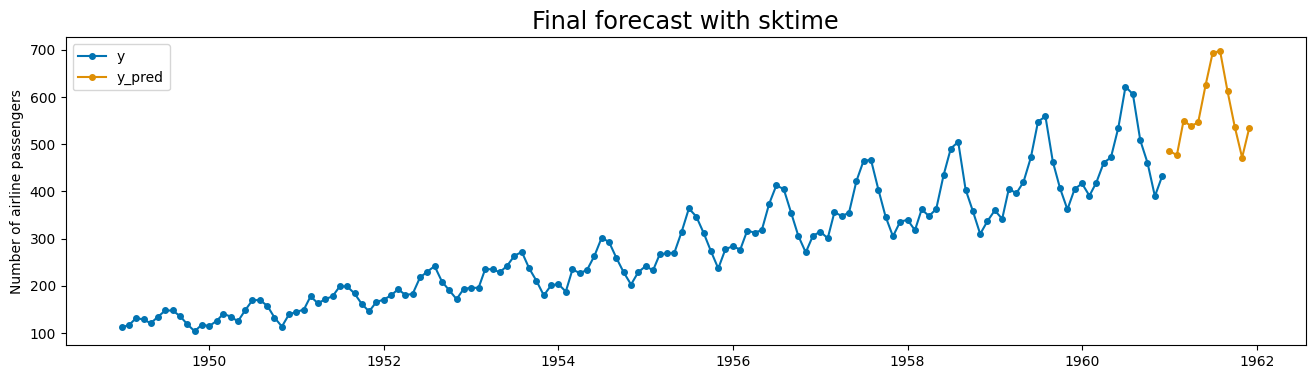

In [33]:
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.forecasting.trend import TrendForecaster
from sktime.transformations.series.boxcox import LogTransformer
from sktime.transformations.series.detrend import Deseasonalizer

y = load_airline()

take_log = LogTransformer()
remove_seasonality = Deseasonalizer(sp=12)
trend_forecaster = TrendForecaster()

forecaster_explicit = TransformedTargetForecaster(
    [take_log, remove_seasonality, trend_forecaster]
)

fh = range(1, 12 + 1)
y_pred = forecaster_explicit.fit_predict(y, fh=fh)

_ = plot_series(y, y_pred, labels=["y", "y_pred"], title="Final forecast with sktime")

### Dunder magic

In [34]:
forecaster_dunder = take_log * remove_seasonality * trend_forecaster

forecaster_dunder

TransformedTargetForecaster(steps=[LogTransformer(), Deseasonalizer(sp=12),
                                   TrendForecaster()])

what happened here?

The "chain" operator `*` creates a "forecasting pipeline"

Has the same interface as all other forecasters! No additional data fiddling!

Transformers "slot in" as standardized components.

### Parameter Estimation

* what if you don't know seasonal periodicity

In [35]:
from sktime.param_est.seasonality import SeasonalityACF
from sktime.transformations.series.difference import Differencer

# compute seasonality on first differences - to make the series stationary first
sp_est = Differencer() * SeasonalityACF()
sp_est.fit(y)

sp_est.get_fitted_params()

{'acf': array([ 1.        ,  0.30279009, -0.10230424, -0.24118718, -0.30023417,
        -0.09421319, -0.07857897, -0.09232524, -0.29459306, -0.19150615,
        -0.10467597,  0.2827635 ,  0.82922657,  0.2843692 , -0.10592295,
        -0.22200376, -0.23088304, -0.06256116, -0.06643473, -0.0903648 ,
        -0.2969042 , -0.16234839]),
 'confint': array([[ 1.        ,  1.        ],
        [ 0.13945976,  0.46612043],
        [-0.27997909,  0.07537061],
        [-0.42042657, -0.06194778],
        [-0.48793181, -0.11253652],
        [-0.29431249,  0.1058861 ],
        [-0.27985813,  0.12270019],
        [-0.29442112,  0.10977063],
        [-0.49781098, -0.09137513],
        [-0.40581392,  0.02280162],
        [-0.32350134,  0.1141494 ],
        [ 0.06260642,  0.50292058],
        [ 0.59958547,  1.05886768],
        [-0.01466569,  0.58340408],
        [-0.41208687,  0.20024097],
        [-0.52914372,  0.0851362 ],
        [-0.54227431,  0.08050823],
        [-0.37848622,  0.2533639 ],
      

and you can estimate and plug the value in a forecaster using `PluginParamsForecaster`

In [36]:
from sktime.forecasting.naive import NaiveForecaster
from sktime.param_est.plugin import PluginParamsForecaster

forecaster = NaiveForecaster(strategy="last")

# can control names using `params`
pipeline = PluginParamsForecaster(sp_est, forecaster)

pipeline.fit_predict(y, fh=fh)

1961-01    417.0
1961-02    391.0
1961-03    419.0
1961-04    461.0
1961-05    472.0
1961-06    535.0
1961-07    622.0
1961-08    606.0
1961-09    508.0
1961-10    461.0
1961-11    390.0
1961-12    432.0
Freq: M, Name: Number of airline passengers, dtype: float64

In [37]:
pipeline

PluginParamsForecaster(forecaster=NaiveForecaster(),
                       param_est=ParamFitterPipeline(param_est=SeasonalityACF(),
                                                     transformers=[Differencer()]))

let's verify that estimated periodicty is used in forecaster

In [38]:
pipeline.forecaster_

NaiveForecaster(sp=12)

### Exogenous predictions

what if you want to use exogenous features, but don't have values during forecast horizon?

...predict `X` first with `ForecastX`, and then pass the estimates to forecaster for `y`

let's load Longley dataset

In [39]:
from sktime.datasets import load_longley

y, X = load_longley()

and split into train+test

In [40]:
from sktime.split import temporal_train_test_split

y_train, y_test, X_train, X_test = temporal_train_test_split(y, X=X, test_size=4)

let's model 3 times

* without X
* with X, by passing known values during both training and prediction phases
* with X, but passing known values only for training

In [41]:
from sktime.forecasting.arima import ARIMA
from sktime.forecasting.compose import ForecastX
from sktime.forecasting.var import VAR

forecaster_without_X = ARIMA()
forecaster_with_X_known = ARIMA()
forecaster_with_X_unknown = ForecastX(ARIMA(), VAR())

fh = [1, 2, 3, 4]

forecaster_without_X.fit(y_train, fh=fh)
forecaster_with_X_known.fit(y_train, X=X_train, fh=fh)
forecaster_with_X_unknown.fit(y_train, X=X_train, fh=fh)

y_pred_without_X = forecaster_without_X.predict()
y_pred_with_X_known = forecaster_with_X_known.predict(X=X_test)
y_pred_with_X_unknown = forecaster_with_X_unknown.predict()

and let's plot now

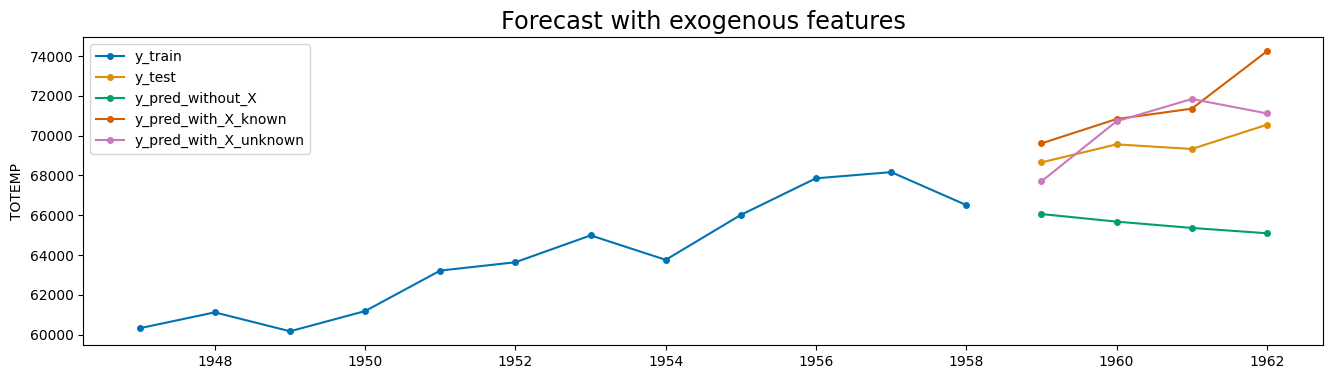

In [42]:
from sktime.utils import plot_series

_ = plot_series(
    y_train,
    y_test,
    y_pred_without_X,
    y_pred_with_X_known,
    y_pred_with_X_unknown,
    labels=[
        "y_train",
        "y_test",
        "y_pred_without_X",
        "y_pred_with_X_known",
        "y_pred_with_X_unknown",
    ],
    title="Forecast with exogenous features",
)

## Parameter tuning

* we want to use a specific forecaster, but not sure about the optimal hyperparameters
* we can use grid or random search - similar interface with `sklearn` with minor adjustments

let's go back to shampoo sales, and split into train+test subsets.

In [43]:
from sktime.datasets import load_shampoo_sales
from sktime.split import temporal_train_test_split

y = load_shampoo_sales()

y_train, y_test = temporal_train_test_split(y, test_size=6)

this time we'll find best parameters ourselves. let's initiate the estimator.

In [44]:
from sktime.forecasting.ets import AutoETS

forecaster = AutoETS(auto=False)

we shall try to find the best combination of the following hyperparameters

In [45]:
param_grid = {
    "error": ["add", "mul"],
    "trend": ["add", "mul"],
    "damped_trend": [True, False],
    "seasonal": ["add", "mul"],
    "sp": [4, 6, 12],
}

and now let's create different cross validation splits

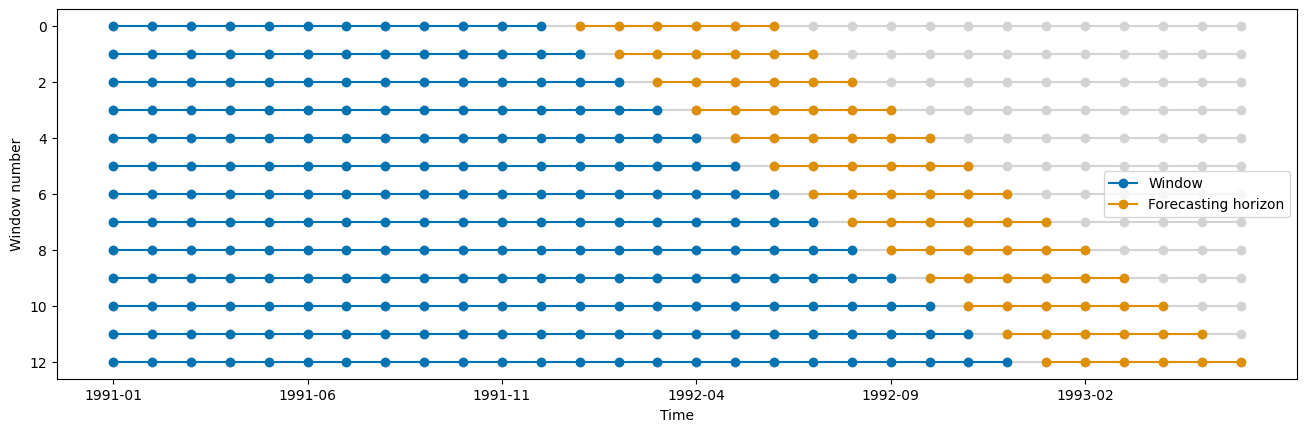

In [46]:
from sktime.split import ExpandingWindowSplitter
from sktime.utils import plot_windows

cv = ExpandingWindowSplitter(fh=range(1, 6 + 1), initial_window=12, step_length=1)
_ = plot_windows(cv, y_train)

let's get into the tuning now

In [47]:
from sktime.forecasting.model_selection import ForecastingGridSearchCV

gscv = ForecastingGridSearchCV(forecaster, cv, param_grid, scoring=smape, n_jobs=-1)
gscv.fit(y_train, fh=range(1, 6 + 1))

ForecastingGridSearchCV(cv=ExpandingWindowSplitter(fh=range(1, 7),
                                                   initial_window=12),
                        forecaster=AutoETS(), n_jobs=-1,
                        param_grid={'damped_trend': [True, False],
                                    'error': ['add', 'mul'],
                                    'seasonal': ['add', 'mul'],
                                    'sp': [4, 6, 12], 'trend': ['add', 'mul']},
                        scoring=MeanAbsolutePercentageError(symmetric=True))

this can be used for prediction directly

In [48]:
gscv.predict()

1993-07    474.133441
1993-08    455.192671
1993-09    512.694378
1993-10    515.249077
1993-11    523.214253
1993-12    550.843171
Freq: M, Name: Number of shampoo sales, dtype: float64

and we can find the optimal hyperparameters, best metrics etc. from `best_*` attributes.

In [49]:
gscv.best_params_

{'damped_trend': False,
 'error': 'add',
 'seasonal': 'add',
 'sp': 12,
 'trend': 'mul'}

In [50]:
gscv.best_score_

0.08967758059495695

results for each split can also be extracted

In [51]:
gscv.cv_results_.head()

,mean_test_MeanAbsolutePercentageError,mean_fit_time,mean_pred_time,params,rank_test_MeanAbsolutePercentageError
0,0.292938,0.129908,0.007181,"{'damped_trend': True, 'error': 'add', 'season...",19.0
1,0.273495,0.113768,0.006482,"{'damped_trend': True, 'error': 'add', 'season...",9.0
2,0.295811,0.220439,0.006365,"{'damped_trend': True, 'error': 'add', 'season...",22.0
3,0.308457,0.145742,0.007129,"{'damped_trend': True, 'error': 'add', 'season...",31.0
4,0.319928,0.719728,0.006804,"{'damped_trend': True, 'error': 'add', 'season...",37.0
5,0.320561,0.133470,0.006763,"{'damped_trend': True, 'error': 'add', 'season...",39.0
6,0.303922,0.101375,0.006736,"{'damped_trend': True, 'error': 'add', 'season...",27.0
7,0.286607,0.099589,0.006238,"{'damped_trend': True, 'error': 'add', 'season...",15.0
8,0.311065,0.117485,0.007559,"{'damped_trend': True, 'error': 'add', 'season...",33.0
9,0.327877,0.165329,0.006666,"{'damped_trend': True, 'error': 'add', 'season...",41.0


## Hierarchical forecasting

<img src="./img/hierarchy.png" alt="Toy hierarchies illustration" style="width: 75%; max-width: 1200px;">

Hierarchical dataframe of historical monthly sales (toy data):

In [52]:
from sktime.datasets import load_hierarchical_sales_toydata
y = load_hierarchical_sales_toydata()

y

Sales
Product line      Product group Date          
Food preparation  Hobs          2000-01  245.0
                                2000-02  144.0
                                2000-03  184.0
                                2000-04  265.0
                                2000-05  236.0
...                                        ...
Food preservation Fridges       2004-08  176.0
                                2004-09  205.0
                                2004-10   59.0
                                2004-11  151.0
                                2004-12  173.0

[240 rows x 1 columns]

At specific date, sales are by hierarchy:

In [53]:
# Multiindex slicing can become important when using hierarchical data!
y.loc[(slice(None), slice(None), "2000-01")]

Sales
Product line      Product group       
Food preparation  Hobs           245.0
                  Ovens          114.0
Food preservation Freezers       164.0
                  Fridges        136.0

visualizing the four sales time series in the hierarchy:

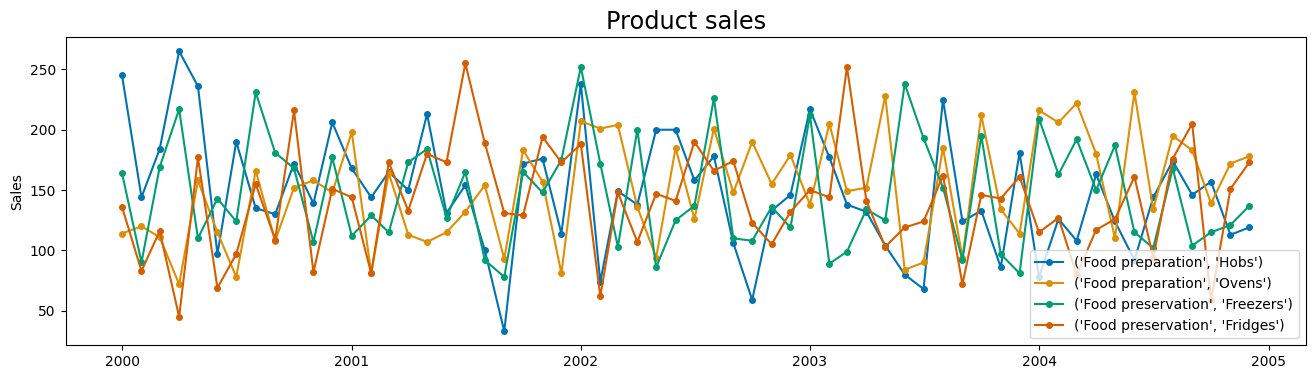

In [54]:
product_index = y.droplevel(-1).index.unique()
fig, ax = plot_series(*(y.loc[idx] for idx in product_index), labels=product_index, title="Product sales")

`sktime` automatically broadcasts non-hierarchical models to hierarchical data.

In [55]:
from sktime.forecasting.ets import AutoETS

forecaster = AutoETS(auto=True)

y_pred = forecaster.fit_predict(y, fh=[1])
y_pred

Sales
Product line      Product group Date               
Food preparation  Hobs          2005-01  119.460419
                  Ovens         2005-01  169.749332
Food preservation Freezers      2005-01  146.466778
                  Fridges       2005-01  139.583316

one forecaster is fitted per node series:

In [56]:
forecaster.get_fitted_params("forecasters")

{'forecasters':                                    forecasters
 Food preparation  Hobs      AutoETS(auto=True)
                   Ovens     AutoETS(auto=True)
 Food preservation Freezers  AutoETS(auto=True)
                   Fridges   AutoETS(auto=True),
 "forecasters.loc[('Food preparation', 'Hobs'),'forecasters']": AutoETS(auto=True),
 "forecasters.loc[('Food preparation', 'Hobs'),'forecasters']__aic": 635.75098832058,
 "forecasters.loc[('Food preparation', 'Hobs'),'forecasters']__aicc": 636.862099431691,
 "forecasters.loc[('Food preparation', 'Hobs'),'forecasters']__bic": 646.2227111316904,
 "forecasters.loc[('Food preparation', 'Hobs'),'forecasters']__hqic": 639.8470547848694,
 "forecasters.loc[('Food preparation', 'Ovens'),'forecasters']": AutoETS(auto=True),
 "forecasters.loc[('Food preparation', 'Ovens'),'forecasters']__aic": 621.2691103924573,
 "forecasters.loc[('Food preparation', 'Ovens'),'forecasters']__aicc": 622.8540160528346,
 "forecasters.loc[('Food preparation', 'Ovens

When working with hierarchies we often want to provide forecasts of the aggregated levels too.

Right now for this we would manually sum up the predictions for the lower levels that we are interested in.

A better way to do this is by using the `Aggregator` transformer in `sktime`.

In [57]:
from sktime.transformations.hierarchical.aggregate import Aggregator

y_hier = Aggregator().fit_transform(y)

y_hier.loc[(slice(None), slice(None), "2000-01")]

Sales
Product line      Product group       
Food preparation  Hobs           245.0
                  Ovens          114.0
                  __total        359.0
Food preservation Freezers       164.0
                  Fridges        136.0
                  __total        300.0
__total           __total        659.0

In [58]:
forecaster = AutoETS(auto=True, random_state=0)

y_hier_pred = forecaster.fit_predict(y_hier, fh=1)
y_hier_pred

Sales
Product line      Product group Date               
Food preparation  Hobs          2005-01  119.460419
                  Ovens         2005-01  169.749332
                  __total       2005-01  298.431496
Food preservation Freezers      2005-01  146.466778
                  Fridges       2005-01  139.583316
                  __total       2005-01  286.049279
__total           __total       2005-01  584.481241

If we compare the predictions at the top level with the sum of the bottom level forecast we can check that they are not the same!

In [59]:
584.481241 - (119.460419 + 169.749332 + 146.466778 + 139.583316)

9.221396000000027

This is because independent instances of each forecaster are fitted per level and there is currently no constrain to ensure the predictions add up.

In [60]:
forecaster.forecasters_

forecasters
Food preparation  Hobs      AutoETS(auto=True, random_state=0)
                  Ovens     AutoETS(auto=True, random_state=0)
                  __total   AutoETS(auto=True, random_state=0)
Food preservation Freezers  AutoETS(auto=True, random_state=0)
                  Fridges   AutoETS(auto=True, random_state=0)
                  __total   AutoETS(auto=True, random_state=0)
__total           __total   AutoETS(auto=True, random_state=0)

We can use `ReconcilerForecaster` enfore hierarchical reconciliation to solve this problem.

The `ReconcilerForecaster` takes in a forecaster and add a reconciliation method.

In [61]:
from sktime.forecasting.reconcile import ReconcilerForecaster

reconciler_forecaster = ReconcilerForecaster(
    forecaster=forecaster.clone(), method="bu"
)

y_hier_pred = reconciler_forecaster.fit_predict(y_hier, fh=1)
y_hier_pred

Sales
Product line      Product group Date               
Food preparation  Hobs          2005-01  119.460419
                  Ovens         2005-01  169.749332
                  __total       2005-01  289.209751
Food preservation Freezers      2005-01  146.466778
                  Fridges       2005-01  139.583316
                  __total       2005-01  286.050094
__total           __total       2005-01  575.259845

Now the top level and sum of the bottom level are the same.

575.259845 - (119.460419 + 169.749332 + 146.466778 + 139.583316)

We can retirieve the available reconciliation methods easily.

In [62]:
print("Valid reconciliation methods:")
for method in ReconcilerForecaster.METHOD_LIST:
    print(f"- {method}")

Valid reconciliation methods:
- mint_cov
- mint_shrink
- wls_var
- bu
- ols
- wls_str
- td_fcst


We can also define different forecasters at different hierarchy levels (or hierarchy nodes) by using the `HierarchyEnsembleForecaster`. 

Forecasters built this way also aggregate the hierachical data for you under the hood.

In [63]:
from sktime.datasets import load_hierarchical_sales_toydata
y = load_hierarchical_sales_toydata()

In [64]:
from sktime.forecasting.compose import HierarchyEnsembleForecaster
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.ets import AutoETS

forecasters = [
    ('Auto ARIMA', AutoARIMA(), 0),
    ('Auto ETS', AutoETS(auto=True), 1)
]

forecaster = HierarchyEnsembleForecaster(
                forecasters=forecasters,
                by='level', default = AutoETS(auto=True)
)

y_pred = forecaster.fit_predict(y, fh=[1])

y_pred

Sales
Product line      Product group Date               
Food preparation  Hobs          2005-01  119.460419
                  Ovens         2005-01  169.749332
                  __total       2005-01  298.431496
Food preservation Freezers      2005-01  146.466778
                  Fridges       2005-01  139.583316
                  __total       2005-01  286.049279
__total           __total       2005-01  585.824587

Up to now, we have been always forecasting the hierachical data locally, but we can also leverage global forecasting:

- Local: fit a model to each time series locally
- Global: fit a single model to all the series

Benefits of global forecasting:
- The model has access to more data to learn from, great when individual time series are short.
- Faster than local approach
- Empirically shown to outperform local models (e.g. M5 forecasting competition)

Note: global models assume the data generating process for the group of time series is the same or at least similar.

In [65]:
from sktime.datasets import load_hierarchical_sales_toydata
from sktime.forecasting.model_selection import temporal_train_test_split

y = load_hierarchical_sales_toydata()

y_train, y_test = temporal_train_test_split(y_hier, test_size=4)

y_test.head()

Sales
Product line      Product group Date          
Food preparation  Hobs          2004-09  146.0
                                2004-10  157.0
                                2004-11  113.0
                                2004-12  119.0
                  Ovens         2004-09  183.0
                                2004-10  139.0
                                2004-11  172.0
                                2004-12  178.0
                  __total       2004-09  329.0
                                2004-10  296.0
                                2004-11  285.0
                                2004-12  297.0
Food preservation Freezers      2004-09  104.0
                                2004-10  115.0
                                2004-11  121.0
                                2004-12  137.0
                  Fridges       2004-09  205.0
                                2004-10   59.0
                                2004-11  151.0
                                2004-12  173.0
                  __total       2004-09  309.0
                                2004-10  174.0
                                2004-11  272.0
                                2004-12  310.0
__total           __total       2004-09  638.0
                                2004-10  470.0
                                2004-11  557.0
                                2004-12  607.0

In [ ]:
y_test.tail()

Let's begin by using local forecasting with a gradient boosting regressor:

In [66]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sktime.forecasting.compose import make_reduction

regressor = HistGradientBoostingRegressor()
forecaster = make_reduction(regressor, strategy="direct", window_length=12, pooling="local")

y_pred = forecaster.fit_predict(y_train, fh=[1, 2, 3, 4])

In [67]:
forecaster.forecasters_

forecasters
Food preparation  Hobs      DirectTabularRegressionForecaster(estimator=Hi...
                  Ovens     DirectTabularRegressionForecaster(estimator=Hi...
                  __total   DirectTabularRegressionForecaster(estimator=Hi...
Food preservation Freezers  DirectTabularRegressionForecaster(estimator=Hi...
                  Fridges   DirectTabularRegressionForecaster(estimator=Hi...
                  __total   DirectTabularRegressionForecaster(estimator=Hi...
__total           __total   DirectTabularRegressionForecaster(estimator=Hi...

We can adapt the error metrics to a hierarchical setting by using `multilevel` argument to obtain scores for each level.

In [68]:
hier_smape = MeanAbsolutePercentageError(symmetric=True, multilevel="raw_values")
errors_local = hier_smape(y_test, y_pred)
errors_local

MeanAbsolutePercentageError
Food preparation  Hobs                         0.134782
                  Ovens                        0.175641
                  __total                      0.076075
Food preservation Freezers                     0.307519
                  Fridges                      0.482346
                  __total                      0.135877
__total           __total                      0.144789

Now with the same regressor, we do global forecasting by setting the `pooling` argument to `global`.

In [69]:
regressor = HistGradientBoostingRegressor()
forecaster = make_reduction(regressor, strategy="direct", window_length=12, pooling="global")

y_pred = forecaster.fit_predict(y_train, fh=[1, 2, 3, 4])

Let's compare the scores for the `local` and `global` approach.

In [70]:
errors_global = hier_smape(y_test, y_pred)

print(f"Average sMAPE with local pooling: {errors_local.mean().iloc[0]:.1%}")
print(f"Average sMAPE with global pooling: {errors_global.mean().iloc[0]:.1%}")

Average sMAPE with local pooling: 20.8%
Average sMAPE with global pooling: 19.4%


### Recap

Quick recap of what we have covered in this notebook:

- Univariate forecasting (stats and ML)
- Univariate with exogenous data
- Multivariate forecasting
- Probabilistic forecasting
- Hierarchical forecasting

Also:

- Searching estimators via `all_estimators`
- Composing estimators from building blocks

### Next:

* feature engineering pipelines
* hyperparameter tuning, autoML
* deep learning and foundation models
* writing `sktime` compatible extensions